# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [3]:
# FIXTURES_IN_SAMPLE
FIS = 8
# FIXTURES_FOR_PLAYER
FFP = 15

In [ ]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Data

In [4]:
df = pd.read_csv('data/fpl_fbref_players.csv')

In [5]:
info = ["Name", "GW"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [6]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

In [7]:
df.shape

(6104, 12)

In [8]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')
df = grouped.filter(lambda x: len(x) >= FFP)

In [9]:
df.shape

(4080, 12)

In [10]:
df.head(FFP)

,Name,GW,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Brenden-Aaronson,4,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,Brenden-Aaronson,5,75.0,0.0,1.0,1.0,0.1,0.1,0.1,0.0,1.0,5.0
2,Brenden-Aaronson,6,90.0,0.0,1.0,0.0,0.0,0.0,0.3,0.0,0.0,2.0
3,Brenden-Aaronson,9,78.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.0,3.0
4,Brenden-Aaronson,10,75.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,0.0,2.0
5,Brenden-Aaronson,11,90.0,0.0,2.0,1.0,0.1,0.1,0.3,0.0,1.0,2.0
6,Brenden-Aaronson,12,90.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0
7,Brenden-Aaronson,13,90.0,0.0,1.0,0.0,0.1,0.1,0.9,0.0,1.0,2.0
8,Brenden-Aaronson,14,90.0,0.0,2.0,0.0,0.2,0.2,0.2,0.0,0.0,2.0
9,Brenden-Aaronson,15,85.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,1.0,2.0


In [11]:
last_names = df["Name"].unique()

# DF to DataLoader

In [12]:
def split_indices(index):
    return (index // (FFP-FIS)), (index % (FFP-FIS))

In [13]:
split_indices(11)

(1, 4)

In [14]:
from torchvision.transforms import ToTensor

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        return len(self.names) * (FFP-FIS)

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = split_indices(idx)
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS - 1)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [15]:
dataset = PandasDataset(df)
dataset.__getitem__(5)

(array([[90. ,  0. ,  2. ,  1. ,  0.1,  0.1,  0.3,  0. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.4,  0. ,  0. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.9,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.2,  0. ,  0. ],
        [85. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.4,  0. ,  0. ],
        [82. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]],
       dtype=float32),
 2.0)

In [16]:
batch_size = 16

In [17]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [18]:
next(iter(dataloader))[1]

tensor([2., 2., 5., 2., 3., 2., 2., 1., 2., 2., 7., 2., 2., 2., 2., 2.])

# LSTM Model

In [19]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [20]:
len(dataloader)

119

In [21]:
torch.transpose(next(iter(dataloader))[0], 0, 1).shape

torch.Size([7, 16, 9])

In [22]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

# Training loop

In [23]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [24]:
%%time
num_epochs = 20
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2)
        # print("INPUTS", inputs.shape)
        # print("TARGETS", targets.shape)
        # print(targets)
        optimizer.zero_grad()
        outputs = net(inputs).flatten()
        # print("OUTPUTS", outputs.shape)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_history.append(running_loss / len(dataloader))
    if epoch % 5 == 0:
        print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')

Epoch 0 Loss: 4.005247695481076
Epoch 5 Loss: 3.5025576706193076
Epoch 10 Loss: 3.1896462325288466
Epoch 15 Loss: 3.127421374581441
CPU times: total: 9min 12s
Wall time: 2min 23s


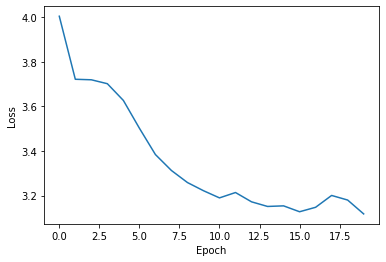

In [25]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions

In [31]:
index = 0
predictions = []
for inputs, target in dataloader:
    inputs = torch.flatten(inputs, 1, 2)
    inputs = inputs.unsqueeze(2)
    # print(inputs)
    outputs = net(inputs)
    for output in outputs:
        player_id, sample_id = split_indices(index)
        name = last_names[player_id]
        points = round(output.item(), 2)
        gw = sample_id + FIS + 1
        predictions.append([name, gw, points])
        # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
        index += 1

In [32]:
pd.DataFrame(predictions, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
1518,Mohamed-Salah,15,5.35
920,Harry-Kane,12,5.29
922,Harry-Kane,14,5.27
58,Miguel-Almiron,11,5.25
173,Harvey-Barnes,14,5.23
1488,Rodrigo,13,5.20
1740,Leandro-Trossard,13,5.20
60,Miguel-Almiron,13,5.19
1517,Mohamed-Salah,14,5.19
773,Erling-Haaland,12,5.16
